# Classificação de Imagens de 38 classes de plantas por tipos de doenças, com Transfer Learning
#### Objetivo: Analisar algumas redes com transfer learning e comparar os resultados, com base na variação de ajustes relacionados a parâmetros de early stop, early rate, camada dropout, camada BatchNormalize e Batchsize.
#### Após análises dos dados de cada uma das 38 classes de imagens e por questão de performance, na execução limitada de processamento, a opção foi por utilizar somente 04 classes de status das condições de folhas de Uva, sendo que uma delas não continha imagens, sendo assim essa descartada.


##### Classes Consideradas:
###### Grape___Black_rot
###### Grape___Esca_(Black_Measles)
###### Grape___healthy


## Legenda:
#### Localização da base de dados no Kaggle: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
#### Base de dados de treino (trainpath): Já separada pelo autor da base de dados, em localização específica no Kaggle.
#### base de dados de validação (validpath): Já separada pelo autor da base de dados, em localização específica no Kaggle. 
## Consultas:
##### https://keras.io/applications/
##### https://www.tensorflow.org/tutorials/load_data/images
##### https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
##### https://keras.io/api/data_loading/

## Leitura do local da base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Mounted at /content/drive


In [ ]:
os.path.abspath(os.getcwd())

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive'

In [ ]:
# Base de imagens para treino com total de xx imagens (classes de tipos de platas)
trainpath = workdir_path + '/classeuva/Train'

# Base de imagens para validação com total de xx imagens (classes de tipos de platas)
validpath = workdir_path + '/classeuva/Valid'

# Base de imagens para validação com total de xx imagens (classes de tipos de platas)
testpath = workdir_path + '/classeuva/Test'


## Leitura de Bibliotecas

In [ ]:
!pip install keras_tqdm
!pip install tf-explain
import numpy as np
import keras as ks
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions 
%matplotlib inline
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import os
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from PIL import Image
from keras import losses
from tensorflow.keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.8 MB/s eta 0:00:00


## Contagem das classes de treino

In [ ]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(trainpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [ ]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Contagem das classes de validação

In [ ]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta

count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(validpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [ ]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Tratar e  Carregar a Base de Treino
##### Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
##### A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imágens
batch_size = 32
# altura da imagem
img_height = 299
# largura da imagem
img_width = 299

In [ ]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de treino
  trainpath,                                                # caminho onde estão as imagens de treino (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                             
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote


Found 4659 files belonging to 3 classes.


In [ ]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
train_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [ ]:
# visualizar o tipo de objeto retornado
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 299 largura
# 299 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Normalizar as imagens de treino para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data_normalized = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.98876315


In [ ]:
# Analisa o resultado da normalização da Base de Treino
for image_batch, labels_batch in train_data_normalized:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Analisa o resultado da normalização da Base de Treino - Formato
train_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# Analisa o resultado da normalização da Base de Treino - Matriz EGB
image_batch[5]

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[0.01568628, 0.        , 0.        ],
        [0.27403763, 0.25220016, 0.25835136],
        [0.35012135, 0.32659194, 0.33443508],
        ...,
        [0.55029863, 0.51108295, 0.5071614 ],
        [0.51426333, 0.47504765, 0.47112608],
        [0.5019608 , 0.46274513, 0.45882356]],

       [[0.01568628, 0.        , 0.        ],
        [0.2764498 , 0.2546123 , 0.26076353],
        [0.3512271 , 0.3276977 , 0.33554083],
        ...,
        [0.5481898 , 0.50897413, 0.50505257],
        [0.54441744, 0.50520176, 0.50128025],
        [0.56347305, 0.52425736, 0.5203358 ]],

       [[0.02573283, 0.00502328, 0.01004656],
        [0.2930693 , 0.2701482 , 0.27738303],
        [0.36428687, 0.34075743, 0.34860057],
        ...,
        [0.5612683 , 0.52205265, 0.5181311 ],
        [0.5738882 , 0.5346725 , 0.53075093],
        [0.60550857, 0.5662929 , 0.5623713 ]],

       ...,

       [[0.02745098, 0.        , 0.        ],
        [0.51

## Tratar e  Carregar a Base de Validação
## Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
## A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 299
# largura da imagem
img_width = 299

In [ ]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

valid_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de validação
  validpath,                                                # caminho onde estão as imagens de validação (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                 
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote

Found 1169 files belonging to 3 classes.


In [ ]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
valid_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [ ]:
# visualizar o tipo de objeto retornado
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 299 largura
# 299 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in valid_data:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Normalizar as imagens de validação para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
valid_data_normalized = valid_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(valid_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.93803173


In [ ]:
# Analisa o resultado da normalização da Base de Validação
for image_batch, labels_batch in valid_data_normalized:
  print(image_batch.shape)
  break

(32, 299, 299, 3)


In [ ]:
# Analisa o resultado da normalização da Base de Validação - Formato
valid_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# Analisa o resultado da normalização da Base de Validação - Matriz EGB
image_batch[2]

<tf.Tensor: shape=(299, 299, 3), dtype=float32, numpy=
array([[[0.02352941, 0.        , 0.        ],
        [0.0481343 , 0.01845367, 0.01230245],
        [0.03480884, 0.00845957, 0.00563972],
        ...,
        [0.03498595, 0.00251166, 0.        ],
        [0.02745098, 0.        , 0.        ],
        [0.02745098, 0.        , 0.        ]],

       [[0.58021516, 0.5505344 , 0.5443832 ],
        [0.60723215, 0.57622457, 0.56874645],
        [0.5551735 , 0.5248846 , 0.51812506],
        ...,
        [0.5466432 , 0.5119574 , 0.49603754],
        [0.5384243 , 0.50482213, 0.48944402],
        [0.52877563, 0.49517345, 0.4797954 ]],

       [[0.7609614 , 0.72958887, 0.7217457 ],
        [0.7807626 , 0.74939007, 0.7415469 ],
        [0.7239262 , 0.69255364, 0.6847105 ],
        ...,
        [0.67411244, 0.6388183 , 0.6192105 ],
        [0.6710898 , 0.6357957 , 0.6161879 ],
        [0.6666667 , 0.6313726 , 0.6117647 ]],

       ...,

       [[0.7490196 , 0.7294118 , 0.7176471 ],
        [0.74

## Resumo Leitura de Imagens
##### 4659 .. 80% testes, 1169 .. 20% validação e xxxxxx  total de imagens

## Modelo de Classificação Xception sem Transfer Learning e Data Augmentation
##### Analisar a resposta da classificação

In [ ]:
## Código consultado em https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206

model = tf.keras.applications.xception.Xception(weights='imagenet', input_shape=(img_height,img_width,3))

# Carrega uma imagem de uma classe (Treino) para verificar a predição nessa Rede, nessas condições.
img = image.load_img(trainpath+"/Grape___healthy/ac753212-e6d7-44b9-9722-4413a7418ab3___Mt.N.V_HL 6178_180deg.JPG", target_size=(img_height,img_width,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=4)[0])


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03991062', 'pot', 0.8326949), ('n12768682', 'buckeye', 0.020133054), ('n07716358', 'zucchini', 0.010261955), ('n12620546', 'hip', 0.006459202)]


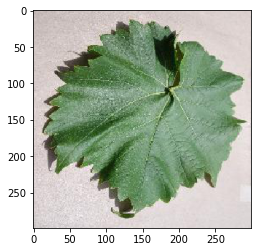

In [ ]:
# Avaliação da assertividade para a classe Tomato___Tomato_mosaic_virus da base de treino
import matplotlib.pylab as plt
plt.imshow(img)

Modelo nessa condição não obteve sucesso na identificação de uma imagem de uma classe. O que era previsto somente comprovando a necessidade de treinar um modelo aplicando Transfer Learning.

In [ ]:
# Visualização das Camadas do Modelo Xception sem Transfer Learning e Data Augmentation
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

## Analisa Camadas Xception Truncada

In [ ]:
base_model_tf=tf.keras.applications.xception.Xception(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)

#Model building
base_model_tf.trainable=False

base_model_tf.summary()


83683744/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
## API Keras https://keras.io/guides/functional_api/
## https://keras.io/guides/sequential_model/

## Modelo Xception Base para Aplicar Transfer Learning


In [ ]:
# Modelo Truncado:
modelo_base = tf.keras.applications.xception.Xception(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)
# "Congelar" as camadas superiores (manter os pesos):
modelo_base.trainable=False
modelo_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

## Modelo Xception Truncado + Camada Dense

*   Aproveitar a base de conhecimento Xception (Imagenet) e seus pesos
*   Treinar essa base adicionando as novas Classes de Treino das Imagens Coletadas



In [ ]:
# from tensorflow.keras.layers import Flatten
sh=Input(shape=(img_height,img_width,3)) # Formato de entrada imagem
conv=tf.cast(sh,tf.float32) 

modelo_dense_1=modelo_base(conv,training=False)
modelo_dense_1=GlobalAveragePooling2D()(modelo_dense_1)
modelo_dense_1=Dropout(0.2)(modelo_dense_1)
modelo_dense_1=ks.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(modelo_dense_1)
modelo_dense_1=Dense(128,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(64,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(3,activation='softmax')(modelo_dense_1)

from keras.models import Model
modelo_final_1=Model(inputs=sh,outputs=modelo_dense_1)
modelo_final_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_12 (Bat  (None, 2048)             8192      
 chNormalization)                                            

In [ ]:
modelo_final_1.layers

In [ ]:
# Definie as métricas
earlystp=EarlyStopping(patience=25, monitor='val_loss') # Evitar um Overfiting do Modelo
metrics = ['accuracy',Precision(),Recall(), AUC()]

In [ ]:
# Compila o Modelo
modelo_final_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=metrics)

In [ ]:
# Processa o modelo com Transfer Learning usando a base de imagens de Treino Normalizada e a base de Validação Normalizada
modelo_final_1_Hist = modelo_final_1.fit(train_data_normalized,validation_data=valid_data_normalized,epochs=200,verbose=1,callbacks=[earlystp])

Epoch 1/200
146/146 [==============================] - 838s 6s/step - loss: 0.2741 - accuracy: 0.9281 - precision: 0.9303 - recall: 0.9255 - auc: 0.9831 - val_loss: 0.2393 - val_accuracy: 0.9162 - val_precision: 0.9362 - val_recall: 0.8914 - val_auc: 0.9874
Epoch 2/200
146/146 [==============================] - 52s 349ms/step - loss: 0.1153 - accuracy: 0.9657 - precision: 0.9680 - recall: 0.9624 - auc: 0.9950 - val_loss: 0.1465 - val_accuracy: 0.9538 - val_precision: 0.9648 - val_recall: 0.9384 - val_auc: 0.9947
Epoch 3/200
146/146 [==============================] - 54s 363ms/step - loss: 0.0751 - accuracy: 0.9730 - precision: 0.9744 - recall: 0.9723 - auc: 0.9981 - val_loss: 0.1041 - val_accuracy: 0.9641 - val_precision: 0.9656 - val_recall: 0.9615 - val_auc: 0.9961
Epoch 4/200
146/146 [==============================] - 56s 383ms/step - loss: 0.0807 - accuracy: 0.9742 - precision: 0.9759 - recall: 0.9717 - auc: 0.9969 - val_loss: 0.0771 - val_accuracy: 0.9718 - val_precision: 0.9742 -

## Análise da Xception - Transfer Learning
##### Métricas:
###### Acurácia: Taxa de acerto do modelo - VP + VN / (VP+VN+FN+FP). Pode mascarar falso positivo e falso negativo.
###### Recall: Taxa de VP entre todas as classes positivas. Varia de 0 a 1 , quanto maior o valor melhor - VP / VP + FN
###### Precisão: Taxa de VP entre os valores Positivos Preditos. VP / VP+FP. Quanto menor a qtd de falsos alarmes melhor.
###### AUC: Relação com a curva ROC (Receiver Operating Characteristic). É a área sob a curva e é recomendada para comparar modelos diferentes. Varia entre 0 e 1 e quanto maior o valor melhor a classificação.

In [ ]:
print(modelo_final_1_Hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


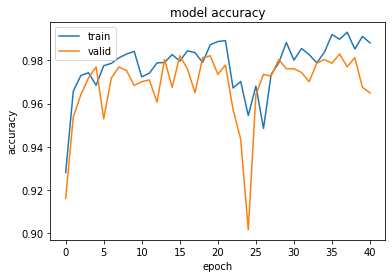

In [ ]:
plt.plot(modelo_final_1_Hist.history['accuracy'])
plt.plot(modelo_final_1_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

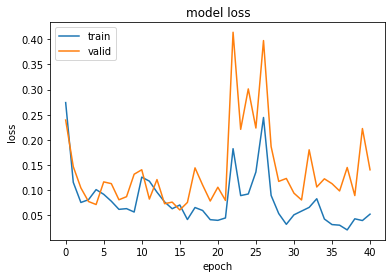

In [ ]:
plt.plot(modelo_final_1_Hist.history['loss'])
plt.plot(modelo_final_1_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

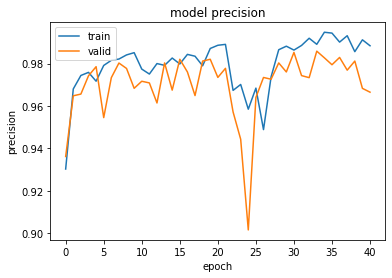

In [ ]:
plt.plot(modelo_final_1_Hist.history['precision'])
plt.plot(modelo_final_1_Hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

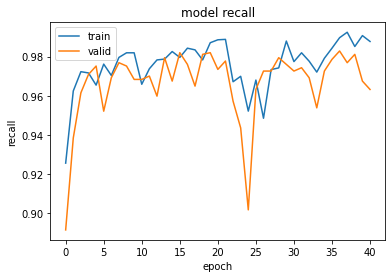

In [ ]:
plt.plot(modelo_final_1_Hist.history['recall'])
plt.plot(modelo_final_1_Hist.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

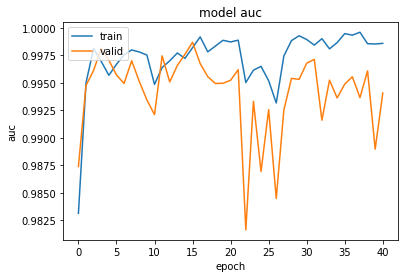

In [ ]:
plt.plot(modelo_final_1_Hist.history['auc'])
plt.plot(modelo_final_1_Hist.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()